## Link prediction using the discrete embeddings

In [1]:
import os
import numpy as np
import pandas as pd
import json
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import random
import copy
from collections import Counter
import lightgbm as lgb
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc, f1_score
from scipy import interp
import gc

In [2]:
graphnames = ['Cora', 'Citeseer', 'Pubmed', 'HomoSapiens', 'Wikipedia', 'BlogCatalog']
graphname = graphnames[0]
emb_size = 50
hop = 2
data_dir = os.path.expanduser("../Graphs/"+graphname)

In [3]:
rwalk_path = data_dir + "/vectors/vectors_rwalk_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(rwalk_path, "r") as read_file:
    rwalk_vectors = json.load(read_file)

In [4]:
ns_path = data_dir + "/vectors/vectors_nodesketch_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(ns_path, "r") as read_file:
    ns_vectors = json.load(read_file)

In [5]:
minwise_path = data_dir + "/vectors/vectors_minwise_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(minwise_path, "r") as read_file:
    minwise_vectors = json.load(read_file)

In [6]:
l1_path = data_dir + "/vectors/vectors_l1_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l1_path, "r") as read_file:
    l1_vectors = json.load(read_file)

In [7]:
l2_path = data_dir + "/vectors/vectors_l2_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l2_path, "r") as read_file:
    l2_vectors = json.load(read_file)

In [8]:
# convert all per-node samples to vectors with categorical features 
def vectors_to_df(path_edges, vectors, x, emb_size=emb_size):
    edges_path = data_dir + path_edges 
    key = list(vectors.keys())[0]
    features = []
    labels = []
    nodes = set()
    edgeset = set()
    print('emb size', emb_size)
    with open(edges_path, 'r') as f:
        for nr, edge in enumerate(f):
            if nr % 10000 == 0:
                print(nr)
            vector_edge = {}
            edge_split = edge.split(':')
            u = edge_split[0].strip()
            v = edge_split[1].strip()
            nodes.add(u)
            nodes.add(v)
            if u not in vectors or v not in vectors:
                continue
            if len(vectors[u]) < emb_size or len(vectors[v]) < emb_size:
                continue
            edgeset.add((u,v))
            for i in range(emb_size): 
                u_i = vectors[u][i] 
                vector_edge['f' + str(2*i)] = str(u_i[x])
                v_i = vectors[v][i]
                vector_edge['f' + str(2*i+1)] = str(v_i[x])
                # vector_edge['f' + str(i)] = int(u_i[x]==v_i[x])
            features.append(vector_edge)
            labels.append(1)
    nr_pos = len(labels)
    print('Number of positive examples', nr_pos)
    nodeslist = list(nodes)
    for l in range(4*nr):
        u = nodeslist[random.randint(0, len(nodeslist)-1)]
        v = nodeslist[random.randint(0, len(nodeslist)-1)]
        if (u, v) not in edgeset and (v, u) not in edgeset:
            if u not in vectors or v not in vectors:
                continue
            if len(vectors[u]) < emb_size or len(vectors[v]) < emb_size:
                continue
            vector_edge = {}
            for i in range(emb_size): 
                u_i = vectors[u][i]
                vector_edge['f' + str(2*i)] = str(u_i[x])
                v_i = vectors[v][i]
                vector_edge['f' + str(2*i+1)] = str(v_i[x])
                #vector_edge['f' + str(i)] = int(u_i[x]==v_i[x])
            features.append(vector_edge)
            labels.append(0)
    print('Number of negative examples', len(labels)-nr_pos)        
    return pd.DataFrame(features), labels

In [9]:
minwise_vectors

{'35': [['227178', 'label=Genetic_Algorithms', 'w-1304'],
  ['1071981', 'label=Reinforcement_Learning', 'w-111'],
  ['509315', 'label=Genetic_Algorithms', 'w-80'],
  ['103482', 'label=Neural_Networks', 'w-225'],
  ['1111304', 'label=Reinforcement_Learning', 'w-244'],
  ['503893', 'label=Genetic_Algorithms', 'w-455'],
  ['1103960', 'label=Genetic_Algorithms', 'w-931'],
  ['231249', 'label=Genetic_Algorithms', 'w-158'],
  ['141324', 'label=Genetic_Algorithms', 'w-528'],
  ['647447', 'label=Genetic_Algorithms', 'w-1297'],
  ['1128201', 'label=Genetic_Algorithms', 'w-582'],
  ['1109199', 'label=Genetic_Algorithms', 'w-25'],
  ['1152896', 'label=Case_Based', 'w-992'],
  ['1128227', 'label=Genetic_Algorithms', 'w-918'],
  ['31105', 'label=Neural_Networks', 'w-239'],
  ['1113551', 'label=Case_Based', 'w-758'],
  ['1103985', 'label=Genetic_Algorithms', 'w-1352'],
  ['31105', 'label=Neural_Networks', 'w-312'],
  ['1105033', 'label=Reinforcement_Learning', 'w-1135'],
  ['1119505', 'label=Genetic

In [10]:
ns_vectors

{'35': [['56119', 'label=Genetic_Algorithms', 'w-500'],
  ['35', 'label=Genetic_Algorithms', 'w-19'],
  ['38205', 'label=Genetic_Algorithms', 'w-1035'],
  ['1688', 'label=Genetic_Algorithms', 'w-1207'],
  ['1153065', 'label=Genetic_Algorithms', 'w-999'],
  ['101143', 'label=Case_Based', 'w-182'],
  ['175291', 'label=Neural_Networks', 'w-592'],
  ['1137466', 'label=Genetic_Algorithms', 'w-507'],
  ['1105033', 'label=Reinforcement_Learning', 'w-1387'],
  ['33904', 'label=Genetic_Algorithms', 'w-446'],
  ['12576', 'label=Genetic_Algorithms', 'w-1381'],
  ['608191', 'label=Genetic_Algorithms', 'w-1177'],
  ['127033', 'label=Genetic_Algorithms', 'w-988'],
  ['634904', 'label=Genetic_Algorithms', 'w-213'],
  ['110041', 'label=Genetic_Algorithms', 'w-778'],
  ['103482', 'label=Neural_Networks', 'w-230'],
  ['8874', 'label=Genetic_Algorithms', 'w-93'],
  ['188318', 'label=Neural_Networks', 'w-696'],
  ['35', 'label=Genetic_Algorithms', 'w-1305'],
  ['576725', 'label=Genetic_Algorithms', 'w-133

In [11]:
x = 2 # indicates what features to use, simply other nodes ids, the node labels or the words describing the nodes

In [12]:
paths = ['graph_nodes.txt', 'labels.txt', 'words_indices.txt']
features_path = data_dir + "/data/" + paths[x] 
features = []
with open(features_path, "r") as features_file:
    for f in features_file:
        features.append(f.strip())

In [13]:
features[:5]

['w-1431', 'w-280', 'w-905', 'w-819', 'w-1107']

In [14]:
X_rwalk, y_rwalk = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=rwalk_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16871


In [15]:
X_ns, y_ns = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=ns_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16867


In [16]:
X_ns.head()

f0     f1    f2      f3      f4      f5      f6     f7     f8     f9  \
0  w-500  w-500  w-19  w-1149  w-1035  w-1035  w-1207   w-97  w-999  w-999   
1  w-500  w-500  w-19  w-1149  w-1035  w-1035  w-1207  w-310  w-999  w-999   
2  w-500  w-500  w-19  w-1149  w-1035  w-1035  w-1207  w-529  w-999  w-999   
3  w-500  w-500  w-19  w-1149  w-1035  w-1035  w-1207  w-310  w-999  w-999   
4  w-500  w-500  w-19  w-1149  w-1035  w-1035  w-1207  w-310  w-999  w-999   

   ...     f90    f91     f92    f93    f94    f95    f96     f97    f98  \
0  ...  w-1296  w-911  w-1263  w-303  w-495  w-495  w-597  w-1247  w-310   
1  ...  w-1296  w-918  w-1263  w-303  w-495  w-495  w-597  w-1247  w-310   
2  ...  w-1296  w-894  w-1263  w-303  w-495  w-495  w-597  w-1247  w-310   
3  ...  w-1296  w-606  w-1263  w-303  w-495  w-495  w-597  w-1247  w-310   
4  ...  w-1296  w-606  w-1263  w-303  w-495  w-495  w-597  w-1247  w-310   

      f99  
0  w-1306  
1  w-1174  
2  w-1306  
3  w-1306  
4  w-1306  

[5 rows x 100 columns]

In [17]:
X_minwise, y_minwise = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=minwise_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16866


In [18]:
X_l1, y_l1 = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=l1_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16861


In [19]:
X_l2, y_l2 = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=l2_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16861


In [20]:
X_val_rwalk, y_val_rwalk = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=rwalk_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4213


In [21]:
for i in range(10):
    print(len(set(X_rwalk["f"+str(i)])), len(set(X_ns["f"+str(i)])), len(set(X_minwise["f"+str(i)])), \
       len(set(X_l1["f"+str(i)])), len(set(X_l2["f"+str(i)]))) 

815 179 76 88 124
814 179 76 88 124
818 114 86 93 131
817 114 86 93 131
814 196 104 68 145
815 196 104 68 145
820 185 101 119 122
819 185 101 119 122
827 163 79 104 115
827 163 79 104 115


In [22]:
X_val_ns, y_val_ns = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=ns_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4213


In [23]:
X_val_minwise, y_val_minwise = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=minwise_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4212


In [24]:
X_val_l1, y_val_l1 = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=l1_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4218


In [25]:
X_val_l2, y_val_l2 = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=l2_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4211


In [26]:
X_rwalk.shape, X_ns.shape, X_minwise.shape, X_l1.shape, X_l2.shape

((21093, 100), (21089, 100), (21088, 100), (21083, 100), (21083, 100))

In [27]:
X_val_rwalk.shape, X_val_ns.shape, X_val_minwise.shape, X_val_l1.shape, X_val_l2.shape

((5269, 100), (5269, 100), (5268, 100), (5274, 100), (5267, 100))

In [28]:
X_val_l1.head(3)

f0      f1      f2      f3     f4     f5      f6     f7     f8      f9  \
0    w-52   w-923  w-1314  w-1314  w-698  w-187  w-1288  w-717  w-969   w-297   
1    w-92     w-4   w-225   w-786  w-382  w-698   w-661    w-4  w-503   w-969   
2  w-1120  w-1120  w-1389  w-1075  w-698  w-698   w-520  w-661  w-969  w-1330   

   ...     f90    f91     f92     f93    f94     f95     f96    f97     f98  \
0  ...   w-819  w-941   w-979   w-979  w-698   w-897  w-1299  w-474  w-1118   
1  ...   w-819  w-762   w-459   w-227  w-415  w-1331   w-474  w-764  w-1379   
2  ...  w-1179  w-700  w-1360  w-1296  w-104   w-698   w-969  w-474   w-104   

      f99  
0  w-1174  
1  w-1118  
2   w-569  

[3 rows x 100 columns]

In [29]:
X_l1.head(3)

f0     f1     f2     f3      f4      f5      f6      f7    f8      f9  \
0  w-464  w-613  w-225  w-225  w-1151  w-1071  w-1288  w-1395  w-17    w-17   
1  w-464   w-92  w-225  w-225  w-1151   w-187  w-1288  w-1395  w-17    w-17   
2  w-464  w-613  w-225  w-225  w-1151   w-382  w-1288  w-1395  w-17  w-1282   

   ...    f90    f91    f92    f93    f94     f95     f96     f97     f98  \
0  ...  w-495  w-819  w-495  w-979  w-580   w-378  w-1299  w-1299  w-1174   
1  ...  w-495  w-819  w-495  w-979  w-580  w-1046  w-1299  w-1299  w-1174   
2  ...  w-495  w-819  w-495  w-979  w-580  w-1046  w-1299  w-1299  w-1174   

      f99  
0  w-1379  
1  w-1379  
2  w-1379  

[3 rows x 100 columns]

In [30]:
def predict(model, X, label_encoder):
    X_local = copy.deepcopy(X)
    for c in X_local.columns: 
        X_c = [str(x) for x in X_local[c]]
        X_local.loc[:, c] = label_encoder.transform(X_c)
    return model.predict(X_local)    
    

In [34]:
def get_mean_acc(X_train, y_train, X_val, y_val, features, nr_iters, res_path):
    
    accs = []  
    f1s = []
    aucs = []
    label_encoder = LabelEncoder()
    label_encoder.fit(features)
    
    X_train = copy.deepcopy(X_train)
        #encoders = {}
    for c in X_train.columns: 
        X_train.loc[:, c] = label_encoder.transform([str(x) for x in X_train[c]])
            
    X_val = copy.deepcopy(X_val)
    for c in X_val.columns: 
        #label_encoder = encoders[c]
        X_val.loc[:, c] = label_encoder.transform([str(x) for x in X_val[c]])
    
    models = [] 
    for i in range(nr_iters):
        print('Iter', i)
        
        X_train_clf, X_test, y_train_clf, y_test =  train_test_split(X_train, y_train, 
                                                                     random_state=i, train_size=0.5)
        clf =  tree.DecisionTreeClassifier() #max_leaf_nodes=100, random_state=0) 
        clf.fit(X_train_clf, y_train_clf)
        models.append(clf)
        y_pred = clf.predict(X_val)
        accuracy = acc(y_val, y_pred)
        accs.append(accuracy)
        
        f1 = f1_score(y_val, y_pred)
        f1s.append(f1)
        
        fpr, tpr, thresholds = roc_curve(y_val, y_pred)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        print('AUC', roc_auc)
        print('F1', f1)
    print('Accuracy', np.mean(accs), np.std(accs))
    print('AUC', np.mean(aucs), np.std(aucs))
    print('F1', np.mean(f1s), np.std(f1s))
    
    
    with open(res_path + "_accuracy.txt", "w") as f:
        f.write(str(np.mean(accs)) + " " + str(np.std(accs)))
    with open(res_path + "_F1.txt", "w") as f:
        f.write(str(np.mean(f1s)) + " " + str(np.std(f1s)))
    with open(res_path + "_AUC.txt", "w") as f:
        f.write(str(np.mean(aucs)) + " " + str(np.std(aucs)))
        
    return models[0], label_encoder
        

    



In [35]:
nr_iters = 10

In [36]:
res_path = data_dir + "/results/rwalk_" + str(emb_size) + "_hop_" + str(hop) 
clf_rw, le = get_mean_acc(X_rwalk, y_rwalk, X_val_rwalk, y_val_rwalk, features, nr_iters, res_path)

Iter 0
AUC 0.5474189512619669
F1 0.28682842287694976
Iter 1
AUC 0.5498061555502809
F1 0.28660994178235555
Iter 2
AUC 0.5428114368225334
F1 0.27763041556145
Iter 3
AUC 0.562117997863755
F1 0.30612244897959184
Iter 4
AUC 0.5393672363319884
F1 0.2746631899174272
Iter 5
AUC 0.5387763074610333
F1 0.27351916376306623
Iter 6
AUC 0.5352196079594904
F1 0.2691475551709217
Iter 7
AUC 0.5484883099928792
F1 0.28770706190061024
Iter 8
AUC 0.5637770492127542
F1 0.30844444444444447
Iter 9
AUC 0.552033883218609
F1 0.29432013769363163
Accuracy 0.6907762383754034 0.008058809118239616
AUC 0.547981693567529 0.009045446320790792
F1 0.28649927820904486 0.012718961016855154


In [37]:
res_path = data_dir + "/results/nodesketch_" + str(emb_size) + "_hop_" + str(hop) 
get_mean_acc(X_ns, y_ns, X_val_ns, y_val_ns, features, nr_iters, res_path)

Iter 0
AUC 0.6261324076271857
F1 0.4021901443504231
Iter 1
AUC 0.6198349355170504
F1 0.3919694072657744
Iter 2
AUC 0.6346538986470449
F1 0.41633858267716534
Iter 3
AUC 0.6215137669119393
F1 0.3944223107569721
Iter 4
AUC 0.6104987538571089
F1 0.3759323719542516
Iter 5
AUC 0.6089658003006567
F1 0.37298387096774194
Iter 6
AUC 0.626947098267268
F1 0.40348330914368646
Iter 7
AUC 0.6345092570614764
F1 0.4153414405986903
Iter 8
AUC 0.624468411266714
F1 0.3994097393015248
Iter 9
AUC 0.623041775456919
F1 0.3970802919708029
Accuracy 0.7662364775099639 0.00468748918460996
AUC 0.6230566104913364 0.00813179120314985
F1 0.3969151468987033 0.013556076715262835


(DecisionTreeClassifier(), LabelEncoder())

In [38]:
res_path = data_dir + "/results/minwise_" + str(emb_size) + "_hop_" + str(hop) 
clf_l0, le_l0 = get_mean_acc(X_minwise, y_minwise, X_val_minwise, y_val_minwise, features, nr_iters, res_path)

Iter 0
AUC 0.6127285137701803
F1 0.3798717316230883
Iter 1
AUC 0.6219540490373823
F1 0.39537126325940214
Iter 2
AUC 0.633456628248295
F1 0.41444114737883286
Iter 3
AUC 0.6233987848571182
F1 0.39758429793658784
Iter 4
AUC 0.6192399421566088
F1 0.3907707412862052
Iter 5
AUC 0.6224437214020547
F1 0.39602977667493794
Iter 6
AUC 0.6322493093326427
F1 0.4119601328903654
Iter 7
AUC 0.6412805944055944
F1 0.42785571142284573
Iter 8
AUC 0.6239801864801865
F1 0.3986186482486433
Iter 9
AUC 0.6308315527065527
F1 0.40974212034383956
Accuracy 0.7686788154897495 0.006432363362780017
AUC 0.6261563282396615 0.007829079039417243
F1 0.4022245571064748 0.013069860639208532


In [39]:
res_path = data_dir + "/results/l1_" + str(emb_size) + "_hop_" + str(hop) 
clf_l1, le_l1 = get_mean_acc(X_l1, y_l1, X_val_l1, y_val_l1, features, nr_iters, res_path)

Iter 0
AUC 0.6220452659597396
F1 0.39555349698934694
Iter 1
AUC 0.6041808105952842
F1 0.36585365853658536
Iter 2
AUC 0.6064350834087676
F1 0.36904761904761907
Iter 3
AUC 0.6018106922712186
F1 0.362227602905569
Iter 4
AUC 0.6111611761282814
F1 0.3778096604495457
Iter 5
AUC 0.6117599357730936
F1 0.37824595786379234
Iter 6
AUC 0.61578489374542
F1 0.3849535906204201
Iter 7
AUC 0.6022787889564206
F1 0.36372269705603044
Iter 8
AUC 0.5947165017888703
F1 0.3487437185929649
Iter 9
AUC 0.6173205202810466
F1 0.38765670202507235
Accuracy 0.7548540007584376 0.0045478202071152826
AUC 0.6087493668908142 0.007923301655979292
F1 0.3733814704086946 0.013314416128837128


In [40]:
res_path = data_dir + "/results/l2_" + str(emb_size) + "_hop_" + str(hop) 
clf_l2, le_l2 = get_mean_acc(X_l2, y_l2, X_val_l2, y_val_l2, features, nr_iters, res_path)

Iter 0
AUC 0.5897092436475897
F1 0.3439128375177641
Iter 1
AUC 0.5907720265466347
F1 0.3459000942507069
Iter 2
AUC 0.5983653247627067
F1 0.3570741097208855
Iter 3
AUC 0.5759898768017385
F1 0.3192948090107738
Iter 4
AUC 0.5877009527716011
F1 0.34018155757286195
Iter 5
AUC 0.5968144398149148
F1 0.35538752362948955
Iter 6
AUC 0.596582813410764
F1 0.35462345090562447
Iter 7
AUC 0.5856634274950886
F1 0.33931034482758626
Iter 8
AUC 0.5878255362938336
F1 0.33976833976833976
Iter 9
AUC 0.6022631698725559
F1 0.3640661938534279
Accuracy 0.738978545661667 0.0051667423724305
AUC 0.5911686811417428 0.0072267540979608
F1 0.34595192610574604 0.01202689678548179


# Interpretability

In [47]:
def decision_path(clf, label_encoder, X_test, y_test, sample_id):
    
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    
    X_test = copy.deepcopy(X_test)
    for c in X_test.columns: 
        #label_encoder = encoders[c]
        X_test.loc[:, c] = label_encoder.transform([str(x) for x in X_test[c]])
    
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)

    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample {id} with class {cl}:\n'.format(id=sample_id, cl=y_test[sample_id]))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        print(feature[node_id])    
        # check if value of the split feature for sample 0 is below threshold
        if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        
        print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
              "{inequality} {threshold})".format(
                  node=node_id,
                  sample=sample_id,
                  feature=feature[node_id],
                  value=label_encoder.inverse_transform([X_test.iloc[sample_id, feature[node_id]]]),
                  inequality=threshold_sign,
                  threshold=threshold[node_id]))
    print("prediction", clf.predict(X_test.iloc[[sample_id]]))

In [48]:
# text_representation = tree.export_text(clf_rw)
# print(text_representation)

In [52]:
decision_path(clf_l1, le_l1, X_val_l1, y_val_l1, 100)

Rules used to predict sample 100 with class 1:

66
decision node 0 : (X_test[100, 66] = ['w-1257']) <= 297.5)
67
decision node 1 : (X_test[100, 67] = ['w-96']) > 297.5)
45
decision node 871 : (X_test[100, 45] = ['w-252']) > 194.0)
62
decision node 1109 : (X_test[100, 62] = ['w-774']) <= 1422.0)
65
decision node 1110 : (X_test[100, 65] = ['w-1174']) <= 1290.0)
8
decision node 1111 : (X_test[100, 8] = ['w-17']) <= 1426.5)
44
decision node 1112 : (X_test[100, 44] = ['w-1171']) <= 770.5)
69
decision node 1113 : (X_test[100, 69] = ['w-1081']) <= 149.0)
68
decision node 1114 : (X_test[100, 68] = ['w-1081']) <= 98.0)
30
decision node 1115 : (X_test[100, 30] = ['w-65']) > 460.5)
97
decision node 1119 : (X_test[100, 97] = ['w-118']) <= 217.5)
62
decision node 1120 : (X_test[100, 62] = ['w-774']) > 878.5)
prediction [1]


In [54]:
decision_path(clf_l1, le_l1, X_val_l1, y_val_l1, 1872)

Rules used to predict sample 1872 with class 0:

66
decision node 0 : (X_test[1872, 66] = ['w-1257']) <= 297.5)
67
decision node 1 : (X_test[1872, 67] = ['w-367']) > 297.5)
45
decision node 871 : (X_test[1872, 45] = ['w-431']) > 194.0)
62
decision node 1109 : (X_test[1872, 62] = ['w-1014']) <= 1422.0)
65
decision node 1110 : (X_test[1872, 65] = ['w-875']) > 1290.0)
64
decision node 1298 : (X_test[1872, 64] = ['w-322']) <= 1279.5)
75
decision node 1299 : (X_test[1872, 75] = ['w-434']) > 312.0)
49
decision node 1301 : (X_test[1872, 49] = ['w-738']) <= 1150.5)
prediction [0]


In [55]:
# text_representation = tree.export_text(clf_l1)
# print(text_representation)

In [63]:
def get_distr(X, y, label, indices):
    
    for idx in indices:
        X_label = X.iloc[[i for i, y_i in enumerate(y) if y_i==label], :]
        # X_neg = X.iloc[[i for i, y_i in enumerate(y) if y_i==0], :]
        print(X_label.shape)

        dict_label = Counter(X_label.iloc[:, idx])
        # dict_neg = Counter(X_neg.iloc[:, idx])

        top_pos = sorted([(cnt/X_label.shape[0], k) for k, cnt in dict_label.items()], reverse=True)[:10]
        plt.bar([i for i in range(len(top_pos))], [c for c, _ in top_pos], alpha=0.7)
        plt.xticks(np.arange(len(top_pos)), [n for cnt, n in top_pos], rotation='vertical')
        # plt.yscale('log')
        plt.ylim([0,0.45])
        plt.show()
    

(4222, 100)


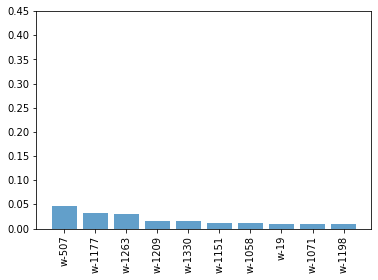

In [64]:
get_distr(X_rwalk, y_rwalk, label=1, indices=[2])

(16855, 100)


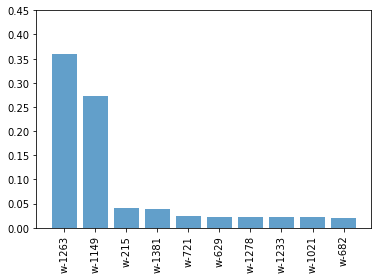

(16855, 100)


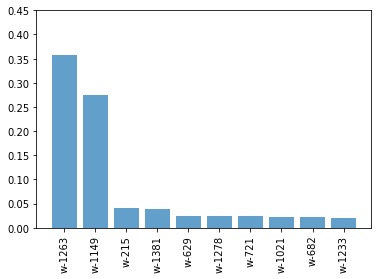

In [65]:
get_distr(X_l2, y_l2, label=0, indices=[16, 17])

(4222, 100)


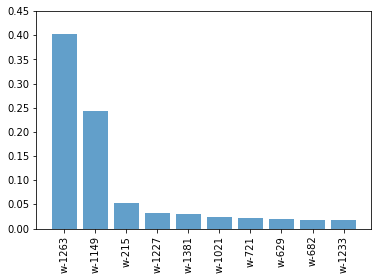

(4222, 100)


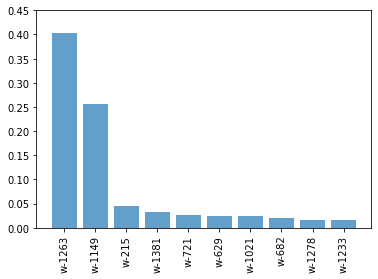

In [66]:
get_distr(X_l2, y_l2, label=1, indices=[16, 17])

In [ ]:
# text_representation = tree.export_text(clf_l2)
# print(text_representation)

# Experiments with Boosting trees 
(not in the paper as even if the results are better, they are much more difficult to interpret)

In [ ]:
# decision_path(clf_l2, le_l2, X_val_l2, y_val_l2, 1)

In [ ]:
# decision_path(clf_l2, le_l2, X_val_l2, y_val_l2, 10000)

In [ ]:
def get_auc_scores(X, y, X_val, y_val, lgb_params, label_encoder, n_splits):
    X_local = copy.deepcopy(X)
    for c in X_local.columns: 
        X_c = [str(x) for x in X_local[c]]
        X_local.loc[:, c] = label_encoder.transform(X_c)
        
    X_val_local = copy.deepcopy(X_val)
    for c in X_val_local.columns: 
        X_c = [str(x) for x in X_val_local[c]]
        X_val_local.loc[:, c] = label_encoder.transform(X_c)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
        
    classifiers = []
    
    folds = StratifiedKFold(n_splits=n_splits, random_state=73, shuffle=True) 
    splits = folds.split(X_local, y)
    for fold_n, (train_index, test_index) in enumerate(splits):
        print('Fold', fold_n)
        X_train, X_test = X_local.iloc[train_index], X_local.iloc[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        print(X_train.shape, X_test.shape)
        dtrain = lgb.Dataset(X_train, label=y_train)
        dtest = lgb.Dataset(X_test, label=y_test)

        clf = lgb.train(lgb_params, dtrain, valid_sets=[dtrain, dtest], verbose_eval=1000)
        classifiers.append((clf, clf.best_iteration))

        y_pred = clf.predict(X_val_local, num_iteration=clf.best_iteration)
        fpr, tpr, thresholds = roc_curve(y_val, y_pred)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        del X_train, X_test, y_train, y_test
        gc.collect()
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)


    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    return mean_auc, std_auc, mean_fpr, mean_tpr, tprs_lower, tprs_upper
    

In [ ]:
def plot_roc_lgbm(X_rw, y_rw, X_rw_val, y_rw_val, \
                  X_mw, y_mw, X_mw_val, y_mw_val, \
                  X_l1, y_l1, X_l1_val, y_l1_val,\
                  features, name, exclude_pred = True, n_splits = 3):
    
    
    label_encoder = LabelEncoder()
    label_encoder.fit(features)
    nr_trees = 3000
    lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'n_estimators':nr_trees,
            'verbose':-1,
            'seed': 1}
    
    mean_auc_rw, std_auc_rw, mean_fpr_rw, mean_tpr_rw, tprs_lower_rw, tprs_upper_rw = \
                get_auc_scores(X_rw, y_rw, X_rw_val, y_rw_val, lgb_params, label_encoder, n_splits)
    
    lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'n_estimators':nr_trees,
            'verbose':-1,
            'seed': 1}
    
    mean_auc_mw, std_auc_mw, mean_fpr_mw, mean_tpr_mw, tprs_lower_mw, tprs_upper_mw = \
                get_auc_scores(X_mw, y_mw, X_mw_val, y_mw_val, lgb_params, label_encoder, n_splits)
    
    lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'n_estimators':nr_trees,
            'verbose':-1,
            'seed': 1}
    
    mean_auc_l1, std_auc_l1, mean_fpr_l1, mean_tpr_l1, tprs_lower_l1, tprs_upper_l1 = \
                get_auc_scores(X_l1, y_l1, X_l1_val, y_l1_val, lgb_params, label_encoder, n_splits)

    alpha = 0.7
    markersize=6
    markevery=5
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=alpha)

    plt.plot(mean_fpr_rw, mean_tpr_rw, color='b',
             label=r'AUC RW = %0.3f $\pm$ %0.4f' % (mean_auc_rw, std_auc_rw),
             lw=1, marker='o', markersize=markersize,  markevery=markevery, alpha=alpha)
   

    plt.plot(mean_fpr_mw, mean_tpr_mw, color='green',
             label=r'AUC $L_0$ = %0.3f $\pm$ %0.4f' % (mean_auc_mw, std_auc_mw),
             lw=1, markevery=markevery, marker='x', markersize=markersize, alpha=alpha)

    
    plt.plot(mean_fpr_l1, mean_tpr_l1, color='orange',
             label=r'AUC $L_1$ = %0.3f $\pm$ %0.4f' % (mean_auc_l1, std_auc_l1),
             lw=1, marker='D', markersize=markersize, markevery=markevery, alpha=alpha)

    plt.xlim([-0.05, 1.2])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    mytitle = name 
    plt.title(mytitle, fontsize=15)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# plot_roc_lgbm(X_rwalk, y_rwalk, X_val_rwalk, y_val_rwalk,
#               X_minwise, y_minwise, X_val_minwise, y_val_minwise,
#               X_l1, y_l1, X_val_l1, y_val_l1,
#               features, graphname +' ROC')

In [ ]:
def lgbm_clf(X, y, X_test, y_test, label_encoder):
        
#         X_local = copy.deepcopy(X)
#         #encoders = {}
#         for c in X.columns: 
#             X_local.loc[:, c] = label_encoder.transform([str(x) for x in X_local[c]])
#             #encoders[c] = label_encoder
            
#         X_test_local = copy.deepcopy(X_test)
#         for c in X_test_local.columns: 
#             #label_encoder = encoders[c]
#             X_c = [str(x) for x in X_test_local[c]]
#             X_test_local.loc[:, c] = label_encoder.transform(X_c)
            
        lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'lambda_l1':10,
            'lambda_l2':10,
            'n_estimators':1000,
            'verbose':-1,
            'seed': 1}
        
        clf = lgb.LGBMClassifier( **lgb_params) 
        clf.fit(X, y, eval_set=[(X, y), (X_test, y_test)], early_stopping_rounds=100, verbose=1000)
        return clf